In [1]:
%pip install bitarray
import math, sys, random
from bitarray import bitarray
from sklearn.utils import murmurhash3_32

class BloomFilter:
    def __init__(self, n_expected, fp_rate, seed=42):
        self.N = int(n_expected)
        self.fp = float(fp_rate)

        # optimal m and k
        self.m = int(math.ceil(-(self.N * math.log(self.fp)) / (math.log(2)**2)))
        self.k = int(math.ceil((self.m / self.N) * math.log(2)))

        self.bits = bitarray(self.m)
        self.bits.setall(0)
        self.seed = seed

    def _hashes(self, key):
        for i in range(self.k):
            h = murmurhash3_32(str(key), seed=self.seed + i) & 0xffffffff
            yield h % self.m

    def insert(self, key):
        for idx in self._hashes(key):
            self.bits[idx] = 1

    def test(self, key):
        return all(self.bits[idx] for idx in self._hashes(key))

    def memory_usage(self):
        return sys.getsizeof(self.bits)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.9/332.9 kB 4.5 MB/s eta 0:00:00


Running 4.1 demo...
Target FP: 0.01 m: 95851 k: 7 Observed FP: 0.006
Target FP: 0.001 m: 143776 k: 10 Observed FP: 0.002
Target FP: 0.0001 m: 191702 k: 14 Observed FP: 0.0

Running 4.2 AOL experiment...
Unique URLs in dataset: 377871
R=262144, k=1, Calculated FP=0.763419, Observed FP=0.830000, Memory=26.00 KB
R=524288, k=1, Calculated FP=0.513604, Observed FP=0.510000, Memory=64.05 KB
R=1048576, k=1, Calculated FP=0.302579, Observed FP=0.290000, Memory=114.85 KB
R=2097152, k=3, Calculated FP=0.072810, Observed FP=0.083000, Memory=251.61 KB
R=4194304, k=7, Calculated FP=0.004899, Observed FP=0.004000, Memory=510.72 KB
R=8388608, k=15, Calculated FP=0.000023, Observed FP=0.001000, Memory=1023.88 KB


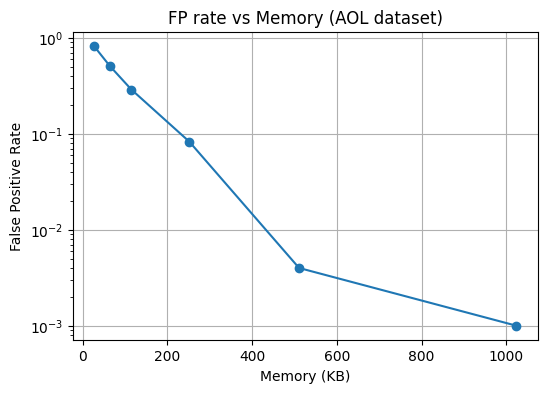

In [2]:
import random, sys, pandas as pd
import matplotlib.pyplot as plt
# from BF import BloomFilter # Removed this line

AOL_URL = "https://cim.mcgill.ca/~dudek/206/Logs/AOL-user-ct-collection/user-ct-test-collection-01.txt"

# 4.1 Demo (warmup, already done)
def demo_fp():
    random.seed(0)
    N = 10000
    membership = random.sample(range(10000, 100000), N)

    # test set: 1000 present, 1000 absent
    present_test = random.sample(membership, 1000)
    absent_test = []
    while len(absent_test) < 1000:
        x = random.randrange(100000, 1000000)
        if x not in membership:
            absent_test.append(x)

    results = []
    for fp_target in [0.01, 0.001, 0.0001]:
        BF = BloomFilter(N, fp_target) # BloomFilter class is used directly
        for x in membership:
            BF.insert(x)

        false_positives = sum(1 for x in absent_test if BF.test(x))
        observed_fp = false_positives / len(absent_test)
        results.append((fp_target, observed_fp, BF.m, BF.k))
        print("Target FP:", fp_target, "m:", BF.m, "k:", BF.k,"Observed FP:", observed_fp)

    return results

def aol_experiment():
    print("Downloading AOL dataset...")
    data = pd.read_csv(AOL_URL, sep="\t", on_bad_lines="skip", low_memory=False)

    urllist = data.ClickURL.dropna().unique()
    # N = len(urllist)
    N = 377871
    print(f"Unique URLs in dataset: {N}")

    # Sample 1000 real + 1000 fake URLs
    true_urls = random.sample(list(urllist), 1000)
    false_urls = [f"fake{random.randint(0,10**9)}.com" for _ in range(1000)]

    # Try different R values (bit array sizes)
    R_values = [2**i for i in range(18, 24)]  # ~256KB to 16MB
    observed_fp, mem_usage = [], []

    for R in R_values:
        k = max(1, int(0.7 * R / N))  # assignment requirement
        # Calculate the theoretical false positive rate for the given R and k
        fp_rate = (1 - math.exp(-k * N / R)) ** k

        BF = BloomFilter(N, fp_rate) # Pass N and calculated fp_rate

        # Insert all dataset URLs
        for url in urllist:
            BF.insert(url)

        # False positives on fake URLs
        fp_count = sum(1 for x in false_urls if BF.test(x))
        fp_rate_observed = fp_count / len(false_urls)

        observed_fp.append(fp_rate_observed)
        mem_usage.append(BF.memory_usage() / 1024)  # KB

        print(f"R={R}, k={k}, Calculated FP={fp_rate:.6f}, Observed FP={fp_rate_observed:.6f}, Memory={mem_usage[-1]:.2f} KB")

    # Plot FP vs memory
    plt.figure(figsize=(6, 4))
    plt.plot(mem_usage, observed_fp, marker="o")
    plt.xlabel("Memory (KB)")
    plt.ylabel("False Positive Rate")
    plt.title("FP rate vs Memory (AOL dataset)")
    plt.yscale("log")
    plt.grid()
    plt.show()

if __name__ == "__main__":
    print("Running 4.1 demo...")
    demo_fp()

    print("\nRunning 4.2 AOL experiment...")
    aol_experiment()